In [257]:

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import make_column_transformer, TransformedTargetRegressor, ColumnTransformer,make_column_selector
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from warnings import filterwarnings 
filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
import seaborn as sns
import scipy as sp
import plotly.express as px


np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(linewidth=150)

In [258]:
dfg = pd.read_csv('C:/Users/kbijjula/OneDrive - Intel Corporation/Documents/Python/AI-course/Module-11/practical_application_II_starter/data/vehicles.csv')

In [259]:
dfg.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7309608375,san luis obispo,800,1999,acura,3.0cl,fair,6 cylinders,gas,220000.0,clean,automatic,NaN,fwd,compact,coupe,white,ca
1,7309211158,richmond,1000,1997,acura,3.0cl,fair,6 cylinders,gas,300000.0,clean,automatic,NaN,fwd,compact,coupe,red,va
2,7313815213,norfolk / hampton roads,3500,1997,acura,3.0cl,excellent,6 cylinders,gas,190000.0,clean,automatic,NaN,fwd,compact,coupe,silver,va
3,7316369180,chicago,5950,2003,acura,3.2 cl type s,excellent,6 cylinders,gas,93763.0,clean,automatic,19UYA42603A011783,fwd,compact,coupe,grey,il
4,7311856092,macon / warner robins,6000,2003,acura,3.2 cl type s,excellent,6 cylinders,gas,186567.0,clean,manual,NaN,fwd,compact,coupe,custom,ga


In [260]:
dfg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211793 entries, 0 to 211792
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            211793 non-null  int64  
 1   region        211793 non-null  object 
 2   price         211793 non-null  int64  
 3   year          211793 non-null  int64  
 4   manufacturer  211793 non-null  object 
 5   model         207771 non-null  object 
 6   condition     132459 non-null  object 
 7   cylinders     139574 non-null  object 
 8   fuel          210522 non-null  object 
 9   odometer      210722 non-null  float64
 10  title_status  208131 non-null  object 
 11  transmission  210887 non-null  object 
 12  VIN           105437 non-null  object 
 13  drive         154830 non-null  object 
 14  size          78724 non-null   object 
 15  type          160470 non-null  object 
 16  paint_color   152761 non-null  object 
 17  state         211793 non-null  object 
dtypes: f

In [261]:
#dropping the "id" and "VIN" columns as they are not relevant
#also dropping the "model" and "region" columns as there are too many unique values to get a reasonable model
dfg=dfg.drop(['id','region', 'model','VIN'], axis = 1)

In [262]:
#dropping rows with empty values in the odometer,fuel, title_status, cylinders, transmission, type and drive columns
# and where the odometer is less than 50 (since they could be classified as new vehicles)
dfg = dfg.dropna()
dfg = dfg[dfg['odometer'] > 50] 

In [263]:
#replacing the empty values in the "condition" column with the average value of "good".
#replacing "other" transmission with the dominant value of "automatic"
dfg['condition'].fillna('good', inplace=True)
dfg['transmission'] = dfg['transmission'].replace(['other'], 'automatic')

In [264]:
dfg.describe(include="all")

,price,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state
count,58275.000000,58275.000000,58275,58275,58275,58275,5.827500e+04,58275,58275,58275,58275,58275,58275,58275
unique,NaN,NaN,47,6,8,5,NaN,6,2,3,4,13,12,51
top,NaN,NaN,ford,excellent,6 cylinders,gas,NaN,clean,automatic,4wd,full-size,sedan,white,ca
freq,NaN,NaN,10470,27526,20358,54089,NaN,54238,53308,23495,30963,16925,13052,6324
mean,12772.329610,2007.468486,NaN,NaN,NaN,NaN,1.288763e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,12024.045651,10.423112,NaN,NaN,NaN,NaN,2.221067e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.000000,1905.000000,NaN,NaN,NaN,NaN,5.100000e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,5200.000000,2005.000000,NaN,NaN,NaN,NaN,7.800000e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,8995.000000,2009.000000,NaN,NaN,NaN,NaN,1.189070e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,16000.000000,2014.000000,NaN,NaN,NaN,NaN,1.608135e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN


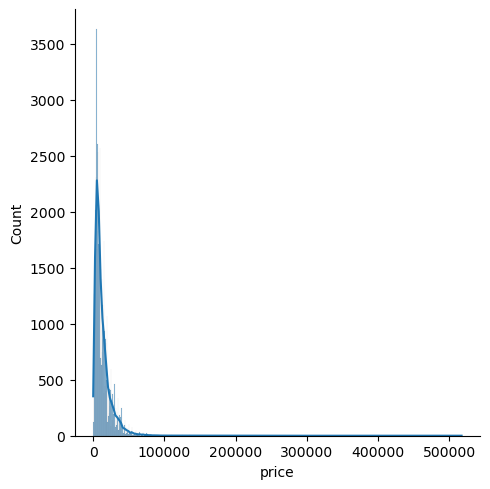

In [265]:
#plotting the price column shows that it could use a log transformation
sns.displot(data=dfg['price'],kde='True')

In [266]:
#splitting the dataset into train and test lists
X = dfg.drop('price', axis = 1)
y = dfg['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.3, random_state=42)

In [280]:
baseline_train = np.ones(shape = y_train.shape)*y_train.mean()
baseline_test = np.ones(shape = y_test.shape)*y_test.mean()
mse_baseline_train = mean_squared_error(baseline_train, y_train)
mse_baseline_test = mean_squared_error(baseline_test, y_test)
print ('baseline train mse :', mse_baseline_train)
print ('baseline test mse :', mse_baseline_test)

baseline train mse : 139705201.6738119
baseline test mse : 155925660.4029029


In [268]:
#using one-hot encoding to transform the categorical values
cats = ["manufacturer", "condition", "cylinders", "fuel", "title_status", 
        "transmission", "drive", "size", "type", "paint_color", "state"]
nums = ["year", "odometer"]

preprocessor = make_column_transformer(
    (OneHotEncoder(drop="if_binary"), cats),
    (StandardScaler(),nums),
    remainder="passthrough",
    verbose_feature_names_out=False
)

### Ordinary Least Squares

In [269]:
#OLS
features = ["year","odometer", "manufacturer", "condition", "cylinders", "fuel", "title_status", 
        "transmission", "drive", "size", "type", "paint_color", "state"]
model1 = Pipeline([
    ('transformer', preprocessor),
    ('linreg',TransformedTargetRegressor(regressor=LinearRegression(), func=np.log10, inverse_func=sp.special.exp10))
])

train_mses = []
test_mses = []

for i in range(1,5):
    poly_ohe = make_column_transformer((PolynomialFeatures(degree=i), make_column_selector(dtype_include=np.number)),
                                           (OneHotEncoder(drop = 'if_binary', sparse = False), cats))
    pipe = Pipeline([('transformer', poly_ohe), ('linreg', LinearRegression())])
    pipe.fit(X_train[features], y_train)
    
    p1 = pipe.predict(X_train[features])
    p2 = pipe.predict(X_test[features])
    
    train_mses.append(mean_squared_error(y_train, p1))
    test_mses.append(mean_squared_error(y_test, p2))

print(train_mses)
print(test_mses)

Lin_df = pd.DataFrame(
    {'Train MSE': train_mses,
     'Test MSE': test_mses
    })


[81321807.37616782, 57043419.03698393, 112868415.50511041, 107901858.5140203]
[91822088.15157898, 71336199.85143924, 127062589.09078632, 122379990.85974906]


In [277]:
Lin_df

,Train MSE,Test MSE
0,8.132181e+07,9.182209e+07
1,5.704342e+07,7.133620e+07
2,1.128684e+08,1.270626e+08
3,1.079019e+08,1.223800e+08


In [281]:
#Calculating feature importance

poly_ohe = make_column_transformer((PolynomialFeatures(degree=1), make_column_selector(dtype_include=np.number)),
                                           (OneHotEncoder(drop = 'if_binary', sparse = False), cats))
pipe = Pipeline([('transformer', poly_ohe), ('linreg', LinearRegression())])
model = pipe.fit(X_train[features], y_train)
r = permutation_importance(model, X_test, y_test, n_repeats=30, random_state=0)
for i in r.importances_mean.argsort()[::-1]:
     if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
         print(f"{X_test.columns.values[i]:<8}"
               f"{r.importances_mean[i]:.3f}"
               f" +/- {r.importances_std[i]:.3f}")

condition0.134 +/- 0.004
year    0.101 +/- 0.002
manufacturer0.092 +/- 0.001
type    0.063 +/- 0.002
drive   0.054 +/- 0.002
fuel    0.049 +/- 0.002
cylinders0.033 +/- 0.001
state   0.021 +/- 0.001
odometer0.021 +/- 0.002
paint_color0.007 +/- 0.000
size    0.005 +/- 0.000
title_status0.004 +/- 0.000
transmission0.004 +/- 0.000


In [282]:
df2=pd.DataFrame()
df2['feature']=X_test.columns.values.tolist()
df2['importance']=r.importances_mean.tolist()

In [283]:
df2

,feature,importance
0,year,0.100723
1,manufacturer,0.092024
2,condition,0.133553
3,cylinders,0.033191
4,fuel,0.049434
5,odometer,0.020587
6,title_status,0.004211
7,transmission,0.003967
8,drive,0.054028
9,size,0.005063


Text(0, 0.5, 'feature importance mean')

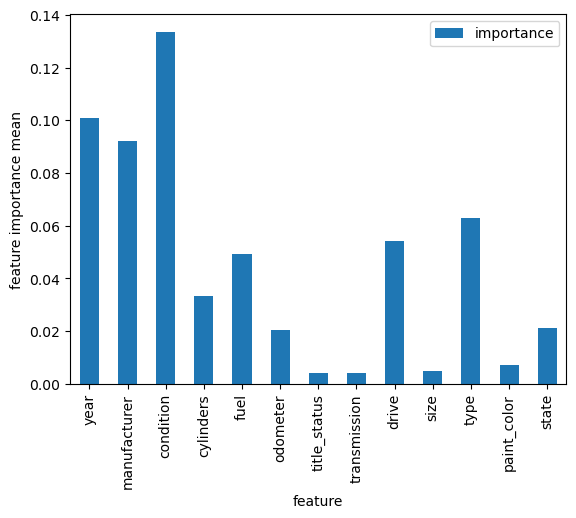

In [284]:
ax6 = df2.plot.bar(x='feature', y='importance', rot=90)
ax6.set_ylabel("feature importance mean")

### Ridge regressor

In [270]:
model_pipe2 = Pipeline([
    ('transformer', preprocessor),
    ('ridge',TransformedTargetRegressor(regressor=Ridge(), func=np.log10, inverse_func=sp.special.exp10))
])
alphaparams2={'ridge__regressor__alpha':10**np.linspace(-10,2,10)}

model2 = GridSearchCV(model_pipe2,
                      param_grid=alphaparams2,
                      cv=5,
                      scoring=('neg_mean_squared_error'), 
                      return_train_score=True, 
                      refit='precision_score')

model2.fit(X_train,y_train)

train_preds = model2.predict(X_train)
test_preds = model2.predict(X_test)
train_mse = mean_squared_error(y_train, train_preds)
test_mse = mean_squared_error(y_test, test_preds)
best_alpha = model2.best_params_


In [271]:
Ridge_df = pd.DataFrame(
    {'Train MSE': train_mse,
     'Test MSE': test_mse,
     'best alpha' : best_alpha
    })
model2_results=pd.concat([pd.DataFrame(model2.cv_results_["params"]),
                         pd.DataFrame(abs(model2.cv_results_["mean_test_score"]), 
                                      columns=["Accuracy"])],axis=1)

In [273]:
model2_results

,ridge__regressor__alpha,Accuracy
0,1.000000e-10,7.836292e+07
1,2.154435e-09,7.836386e+07
2,4.641589e-08,7.836192e+07
3,1.000000e-06,7.836371e+07
4,2.154435e-05,7.836394e+07
5,4.641589e-04,7.836224e+07
6,1.000000e-02,7.836404e+07
7,2.154435e-01,7.844942e+07
8,4.641589e+00,7.968594e+07
9,1.000000e+02,8.264189e+07


[None]

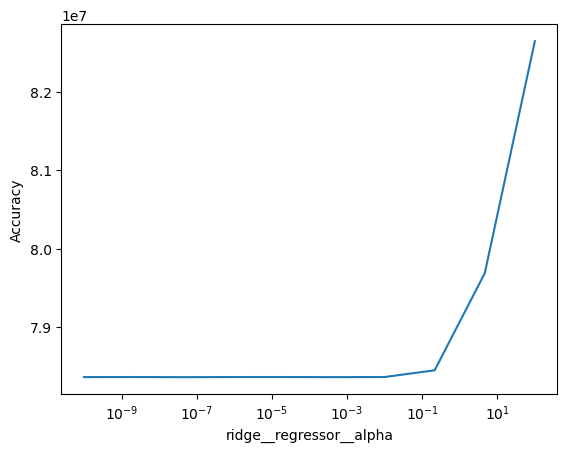

In [276]:
#fig2 = px.line(model2_results, x="ridge__regressor__alpha", y="Accuracy", title='Accuracy vs alpha',log_x=True)
#fig2.show()
rpl = sns.lineplot(data=model2_results, x="ridge__regressor__alpha", y="Accuracy")
rpl.set(xscale='log')

In [250]:
Ridge_df

,Train MSE,Test MSE,best alpha
ridge__regressor__alpha,7.789860e+07,8.420848e+07,4.641589e-08
